In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from data_preprocessing import *
from implementation import *
from helpers import *
from plot import *

### Categorize the data and remove columns

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [4]:
groups = categorize(y, tX, ids)

In [5]:
for i, (y, tX, ids) in enumerate(groups):
    tX = remove_uniform_col(tX)
    groups[i] = (y, tX, ids)

### Cleaning, removing outliers, without stardadizing the data

In [6]:
non_correlated_cols = []

for i, (y, tX, ids) in enumerate(groups):
    y = change_y(y)
    non_correlated_cols.append(non_correlated_col(tX))
    
    x, mean_x, std_x = clean(tX)
    y, x = remove_outliers(y, x, mean_x, std_x)
    x = x[:, non_correlated_cols[i]]
    
    groups[i] = (y, x, ids)

### Least squares with normal equations

In [7]:
weights = []
y_preds = []

for y, x, ids in groups:
    w, _ = least_squares(y, x)
    y_pred = predict_labels(w, x)
    
    weights.append(w)
    y_preds.append(y_pred)

y_pred = np.concatenate(y_preds)
y_label = np.concatenate([y for (y, _, _) in groups])

accuracy_score(y_pred, y_label)

0.7694006656821037

### Ridge Regression

In [8]:
### cross Validation to find lambda
lambdas = np.logspace(-4, 0, 30)
accuracies = []

for y, x, ids in groups:
    accuracy = ridge_cross_validation(y, x, lambdas)
    accuracies.append(accuracy)

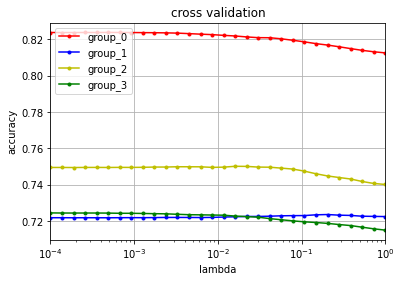

In [9]:
ridge_cross_validation_visualization(lambdas, accuracies)

In [10]:
### select lambdas with the highest average accuracy
best_lambda = lambdas[np.argmax(np.mean(accuracies, axis=0))]
print(best_lambda)

0.0001


In [11]:
weights = []
y_preds = []

for y, x, ids in groups:
    w, _ = ridge_regression(y, x, best_lambda)
    y_pred = predict_labels(w, x)
    
    weights.append(w)
    y_preds.append(y_pred)

y_pred = np.concatenate(y_preds)
y_label = np.concatenate([y for (y, _, _) in groups])

accuracy_score(y_pred, y_label)

0.7694138911543633

### Add polynomial basis

In [12]:
polys = np.arange(1, 13)
accuracies = []

for y, x, ids in groups:
    accuracy = poly_cross_validation(y, x, best_lambda, polys)
    accuracies.append(accuracy)

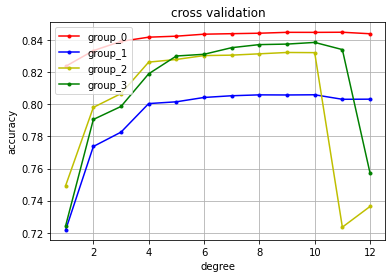

In [13]:
poly_cross_validation_visualization(polys, accuracies)

In [14]:
# we choose a degree of 6 to have substantial performance while avoiding overfitting
for i, (y, x, ids) in enumerate(groups):
    x = build_poly(x, 6)
    groups[i] = (y, x, ids)

In [15]:
# using ridge regression
weights = []
y_preds = []

for y, x, ids in groups:
    w, _ = ridge_regression(y, x, best_lambda)
    y_pred = predict_labels(w, x)
    
    weights.append(w)
    y_preds.append(y_pred)

y_pred = np.concatenate(y_preds)
y_label = np.concatenate([y for (y, _, _) in groups])

accuracy_score(y_pred, y_label)

0.8277294068375691

In [16]:
# using least squares
weights = []
y_preds = []

for y, x, ids in groups:
    w, _ = least_squares(y, x)
    y_pred = predict_labels(w, x)
    
    weights.append(w)
    y_preds.append(y_pred)

y_pred = np.concatenate(y_preds)
y_label = np.concatenate([y for (y, _, _) in groups])

accuracy_score(y_pred, y_label)

0.8278396191063989

### APPYING TO TEST

In [17]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [18]:
groups_test = categorize(y_test, tX_test, ids_test)

In [19]:
for i, (y_test, tX_test, ids_test) in enumerate(groups_test):
    tX_test = remove_uniform_col(tX_test)
    groups_test[i] = (y_test, tX_test, ids_test)

In [20]:
for i, (y_test, tX_test, ids_test) in enumerate(groups_test):
    y_test = change_y(y_test)
    
    x_test, mean_x_test, std_x_test = clean(tX_test)
    x_test = x_test[:, non_correlated_cols[i]]
    
    groups_test[i] = (y_test, x_test, ids_test)

In [21]:
for i, (y_test, x_test, ids_test) in enumerate(groups_test):
    x_test = build_poly(x_test, 6)
    groups_test[i] = (y_test, x_test, ids_test)

In [22]:
y_preds_test = []
for i, (y_test, x_test, ids_test) in enumerate(groups_test):
    y_pred_test = predict_labels(weights[i], x_test)
    y_preds_test.append(y_pred_test)
    
y_pred_test = np.concatenate(y_preds_test)
y_pred_test = unchange_y(y_pred_test)

g_ids_test = np.concatenate([ids_test for (_, _, ids_test) in groups_test])

In [23]:
OUTPUT_PATH = '../data/sample-submission.csv' # TODO: fill in desired name of output file for submission
create_csv_submission(g_ids_test, y_pred_test, OUTPUT_PATH)